# Impact of `p_error` on neural networks

This tutorial aims to show the effect of the hyperparameter `p_error` on neural networks during Fully Homomorphic Encryption (FHE) execution.

At Zama, non-linear operations are implemented using table lookup (TLU), which are implemented
through the Programmable Bootstrapping technology (PBS). The hyperparameter `p_error` represents the probability of a single PBS operation being incorrect. For further information on `p_error`, please refer to this [link](https://docs.zama.ai/concrete-ml/explanations/advanced_features).

<!-- Separate FMNIST from CIFAR directory -->
<!-- #FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/3552 -->

### import required packages

In [1]:
import random
from itertools import chain
from time import time

import matplotlib.pylab as plt
import numpy
import torch
from cifar_utils import get_dataloader, mapping_keys, plot_dataset, torch_inference, train
from sklearn.metrics import top_k_accuracy_score

from concrete.ml.pytest.torch_models import QNNFashionMNIST
from concrete.ml.pytest.utils import data_calibration_processing
from concrete.ml.search_parameters import BinarySearch
from concrete.ml.torch.compile import compile_brevitas_qat_model

### Setting 

In [2]:
param = {
    "batch_size": 128,
    "dataset_name": "FashionMNIST",
    "quant_state_dict": "./checkpoints/FashionMNIST/quant/FashionMNIST_quant_state_dict.pt",
    "fp32_state_dict": "./checkpoints/FashionMNIST/fp32/FashionMNIST_fp32_state_dict.pt",
    "seed": 42,
}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device Type: {device}")

Device Type: cuda:0


### Display the FashionMnist data

For this experiment, we have chosen the FashionMnist data-set.

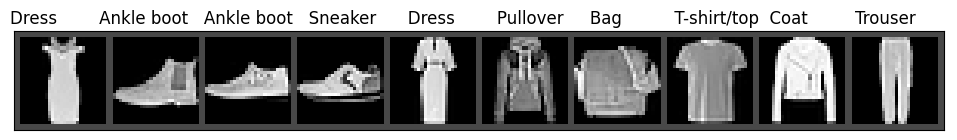

In [3]:
train_loader, test_loader = get_dataloader(param=param)

plot_dataset(test_loader, param)

### Load model

In [4]:
# Choose a lower quantization bit to get reasonable compilation and inference time
quant_model = QNNFashionMNIST(n_bits=2)

training = False

if training:
    # To train the Fashion MNIST model, first, we assign float32 weights, and we then fine-tune
    # the weights using Quantization Aware Training

    param = {
        **param,
        # Add some parameters required for the training
        **{
            "accuracy_test": [],
            "accuracy_train": [],
            "loss_test_history": [],
            "loss_train_history": [],
            "dir": "./checkpoints/FashionMNIST",
            "criterion": torch.nn.CrossEntropyLoss(),
            "training": "quant",
            "lr": 0.001,
            "epochs": 30,
            "gamma": 0.01,
            "milestones": [100],
        },
    }

    checkpoint = torch.load(param["fp32_state_dict"], map_location=device)
    quant_model = mapping_keys(checkpoint, quant_model, device)
    print(
        "Accuracy before fine-tuning:"
        f"{torch_inference(quant_model, test_loader, param, device): .4f}"
    )
    quant_model = train(quant_model, train_loader, test_loader, param, device=device)
else:
    # Upload directly pre-tained weights
    checkpoint = torch.load(param["quant_state_dict"], map_location="cpu")
    quant_model.load_state_dict(checkpoint)

print(f"Accuracy: {torch_inference(quant_model, test_loader, param, device):.4%}")

# GPU mode is still not supported yet
quant_model = quant_model.cpu()

Accuracy: 70.4327%


### Data

In [5]:
# Data for calibration and compilation
X_calib, y_calib = data_calibration_processing(data=train_loader, n_sample=60)

# Testing set for the FHE simulation mode
X_test, y_test = data_calibration_processing(data=train_loader, n_sample=100)

# For the FHE execution, 1 sample is used to measure the inference time
X_fhe_test, y_fhe_test = data_calibration_processing(data=test_loader, n_sample=1)

In [6]:
inference_time, compilation_time, simulated_accuracy = [], [], []

# `p_error` is bounded between 0 and 0.9
# Generate random p_error values with different ranges of scales, such as:
# 0.00001, 0.0001, 0.001, 0.01, and 0.1. In order to measure the inference time
random_p_errors = list(
    chain(
        *[
            [random.uniform(a, b) for _ in range(4)]
            for a, b in [(0.00001, 0.0001), (0.0001, 0.001), (0.001, 0.01), (0.01, 0.9)]
        ]
    )
)

for i, p_error in enumerate(random_p_errors):

    start_time = time()
    qmodel = compile_brevitas_qat_model(
        torch_model=quant_model, torch_inputset=X_calib, p_error=p_error
    )
    compilation_time.append((time() - start_time) / 60.0)

    # Key Generation.
    qmodel.fhe_circuit.keygen(force=False)

    # Evaluating the model compiled with a given `p_error` in FHE simulation mode
    y_pred_simulated = qmodel.forward(X_test, fhe="simulate")
    simulated_accuracy.append((y_pred_simulated.argmax(axis=1) == y_test).mean())

    # Measuring the inference time for a model compiled with a given `p_error` in real FHE mode
    # on 1 single example
    start_time = time()
    _ = qmodel.forward(X_fhe_test, fhe="execute")
    inference_time.append((time() - start_time) / 60.0)

    print(
        f"Iter: {i:2} - p_error={p_error:1.9f}, accuracy={simulated_accuracy[-1]:.2%} "
        f"inference_time={inference_time[-1]:1.4f}, compilation_time={compilation_time[-1]:1.4f}, ",
        f"max_bitwidth={qmodel.fhe_circuit.graph.maximum_integer_bit_width()}",
    )

Iter:  0 - p_error=0.000067548, accuracy=70.00% inference_time=7.1393, compilation_time=0.0347,  max_bitwidth=7
Iter:  1 - p_error=0.000012251, accuracy=70.00% inference_time=7.2961, compilation_time=0.0345,  max_bitwidth=7
Iter:  2 - p_error=0.000034753, accuracy=70.00% inference_time=7.1990, compilation_time=0.0347,  max_bitwidth=7
Iter:  3 - p_error=0.000030089, accuracy=70.00% inference_time=7.2431, compilation_time=0.0358,  max_bitwidth=7
Iter:  4 - p_error=0.000762824, accuracy=72.00% inference_time=7.0666, compilation_time=0.0350,  max_bitwidth=7
Iter:  5 - p_error=0.000709030, accuracy=72.00% inference_time=6.9790, compilation_time=0.0342,  max_bitwidth=7
Iter:  6 - p_error=0.000902962, accuracy=69.00% inference_time=7.1151, compilation_time=0.0346,  max_bitwidth=7
Iter:  7 - p_error=0.000178245, accuracy=70.00% inference_time=7.1713, compilation_time=0.0345,  max_bitwidth=7
Iter:  8 - p_error=0.004797296, accuracy=71.00% inference_time=6.8009, compilation_time=0.0348,  max_bit

### Visualize the impact of `p_error`

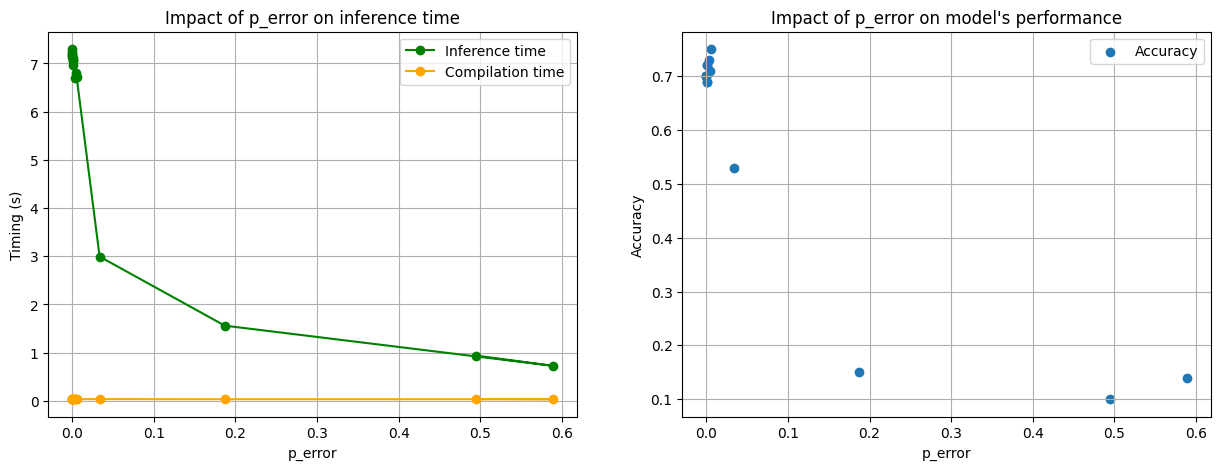

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(random_p_errors, inference_time, label="Inference time", color="green", marker="o")
axes[0].plot(
    random_p_errors, compilation_time, label="Compilation time", color="orange", marker="o"
)
axes[1].scatter(random_p_errors, simulated_accuracy, label="Accuracy", marker="o")

axes[0].set_title("Impact of p_error on inference time")
axes[1].set_title("Impact of p_error on model's performance")

axes[0].set_ylabel("Timing (s)")
axes[1].set_ylabel("Accuracy")

axes[0].set_xlabel("p_error")
axes[1].set_xlabel("p_error")

axes[0].grid(True)
axes[1].grid(True)

axes[0].legend()
axes[1].legend()

plt.show();

As the value of `p_error` increases, the inference time in FHE decreases, but the model's performance is affected. For custom ML models, it is recommended to search in simulated FHE mode to find a `p_error` that offers an interesting compromise between accuracy and execution time. In Concrete ML, we have proposed a binary search algorthm showed in [Searching for the best error probability](https://docs.zama.ai/concrete-ml/explanations/advanced_features).

### Binary search algorithm

In [23]:
search = BinarySearch(estimator=quant_model, predict="predict", metric=top_k_accuracy_score, k=1)

largest_p_error = search.run(x=X_calib, ground_truth=y_calib, max_iter=30, verbose=False)

# Compile the model with the optimal `p_error`
qmodel = compile_brevitas_qat_model(
    torch_model=quant_model, torch_inputset=X_calib, p_error=largest_p_error
)

# Key Generation
qmodel.fhe_circuit.keygen(force=False)

start_time = time()
_ = qmodel.forward(X_fhe_test, fhe="execute")
delta_time = (time() - start_time) / 60.0

y_pred = qmodel.forward(X_test, fhe="simulate")
accuracy = top_k_accuracy_score(y_true=y_test, y_score=y_pred, k=1, labels=numpy.arange(10))

print(
    f"With p_error = {largest_p_error:.5f}, "
    f"the inference time per example becomes {delta_time / len(y_fhe_test):.2f}s and "
    f"accuracy = {accuracy:.2%}"
)

With p_error = 0.00121, the inference time per example becomes 7.04s and accuracy = 73.00%
